<a href="https://colab.research.google.com/github/sommnathrwategaonkar/Lung-Cancer/blob/main/V1%20MobileNetV2%20%2B%20Grad-CAM%20%2B%20Post-Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📥 Upload Train - Normal:


Saving normal_001.png to normal_001 (5).png
📥 Upload Train - Abnormal:


Saving abnormal_001.png to abnormal_001 (6).png
Saving abnormal_002.png to abnormal_002 (6).png
Saving abnormal_003.png to abnormal_003 (6).png
Saving abnormal_004.png to abnormal_004 (1).png
Saving abnormal_005.png to abnormal_005 (1).png
Saving abnormal_006.png to abnormal_006 (1).png
Saving abnormal_007.png to abnormal_007.png
Saving abnormal_008.png to abnormal_008.png
Saving abnormal_009.png to abnormal_009.png
Saving abnormal_010.png to abnormal_010.png
Saving abnormal_011.png to abnormal_011.png
Saving abnormal_012.png to abnormal_012.png
Saving abnormal_013.png to abnormal_013.png
Saving abnormal_014.png to abnormal_014.png
Saving abnormal_015.png to abnormal_015.png
Saving abnormal_016.png to abnormal_016.png
Saving abnormal_017.png to abnormal_017.png
Saving abnormal_018.png to abnormal_018.png
Saving abnormal_019.png to abnormal_019.png
Saving abnormal_020.png to abnormal_020.png
Saving abnormal_021.png to abnormal_021.png
Saving abnormal_022.png to abnormal_022.png
Saving a

Saving normal_001.png to normal_001 (5).png
📥 Upload Val - Abnormal:


Saving abnormal_001.png to abnormal_001 (6).png
Saving abnormal_002.png to abnormal_002 (6).png
Saving abnormal_003.png to abnormal_003 (6).png
Saving abnormal_004.png to abnormal_004 (1).png
Saving abnormal_005.png to abnormal_005 (1).png
Saving abnormal_006.png to abnormal_006 (1).png
Saving abnormal_007.png to abnormal_007.png
Saving abnormal_008.png to abnormal_008.png
Saving abnormal_009.png to abnormal_009.png
Saving abnormal_010.png to abnormal_010.png
Saving abnormal_011.png to abnormal_011.png
Saving abnormal_012.png to abnormal_012.png
Saving abnormal_013.png to abnormal_013.png
Saving abnormal_014.png to abnormal_014.png
Saving abnormal_015.png to abnormal_015.png
Saving abnormal_016.png to abnormal_016.png
Saving abnormal_017.png to abnormal_017.png
Saving abnormal_018.png to abnormal_018.png
Saving abnormal_019.png to abnormal_019.png
Saving abnormal_020.png to abnormal_020.png
Saving abnormal_021.png to abnormal_021.png
Saving abnormal_022.png to abnormal_022.png
Saving a

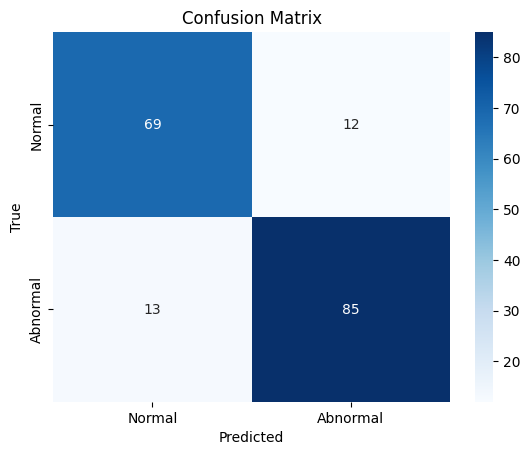


📸 Upload abnormal image for Grad-CAM:


Saving abnormal_001.png to abnormal_001 (6).png
Saving abnormal_002.png to abnormal_002 (6).png
Saving abnormal_003.png to abnormal_003 (6).png


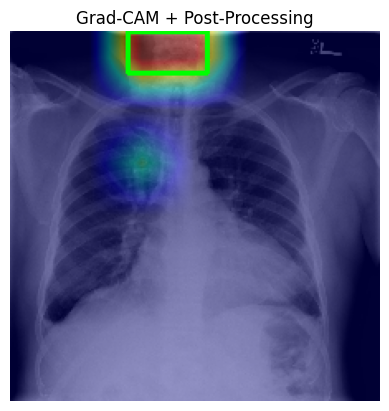

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# ✅ 1. Import Required Libraries
import os, shutil, numpy as np, cv2, matplotlib.pyplot as plt, seaborn as sns, warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from google.colab import files
from PIL import Image

# ✅ 2. Prepare Dataset Folders
base_dir = "/content/lung_data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

for d in [train_dir, val_dir]:
    for cls in ['Normal', 'Abnormal']:
        os.makedirs(os.path.join(d, cls), exist_ok=True)

# ✅ 3. Upload Train and Validation Images
print("📥 Upload Train - Normal:")
for f in files.upload().keys():
    shutil.move(f, os.path.join(train_dir, 'Normal', f))

print("📥 Upload Train - Abnormal:")
for f in files.upload().keys():
    shutil.move(f, os.path.join(train_dir, 'Abnormal', f))

print("📥 Upload Val - Normal:")
for f in files.upload().keys():
    shutil.move(f, os.path.join(val_dir, 'Normal', f))

print("📥 Upload Val - Abnormal:")
for f in files.upload().keys():
    shutil.move(f, os.path.join(val_dir, 'Abnormal', f))

# ✅ 4. Data Generators
img_size = (224, 224)
batch_size = 8

train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True
).flow_from_directory(train_dir, target_size=img_size, batch_size=batch_size, class_mode='binary')

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
).flow_from_directory(val_dir, target_size=img_size, batch_size=batch_size, class_mode='binary', shuffle=False)

# ✅ 5. Compute Class Weights
labels = train_gen.classes
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# ✅ 6. Focal Loss Function
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred, label_smoothing=0.1)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        fl = alpha * tf.pow(1 - p_t, gamma) * bce
        return tf.reduce_mean(fl)
    return loss_fn

# ✅ 7. Build Fine-Tuned MobileNetV2 Model
def build_model():
    inputs = Input(shape=(224, 224, 3))
    base = MobileNetV2(include_top=False, weights='imagenet', input_tensor=inputs)
    for layer in base.layers[-40:]:
        layer.trainable = True
    for layer in base.layers[:-40]:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base.output)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)
    return Model(inputs, output)

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=focal_loss(gamma=2., alpha=0.25),
              metrics=['accuracy'])

# ✅ 8. Train the Model with Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=35,
    class_weight=class_weights,
    callbacks=callbacks
)

# ✅ 9. Evaluate Performance
val_gen.reset()
preds = model.predict(val_gen)
y_pred = (preds > 0.5).astype(int).reshape(-1)
y_true = val_gen.classes

# ✅ 10. Classification Report & Confusion Matrix
print("\n📊 Classification Report:")
report = classification_report(y_true, y_pred, target_names=["Normal", "Abnormal"], output_dict=True)
for cls in ["Normal", "Abnormal"]:
    print(f"{cls} - Precision: {report[cls]['precision']:.2f}, Recall: {report[cls]['recall']:.2f}, F1: {report[cls]['f1-score']:.2f}")

cm = confusion_matrix(y_true, y_pred)
TP = cm[1][1]
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]

print("\n📌 Confusion Matrix:")
print(f"[[TN={TN}  FP={FP}]\n [FN={FN}  TP={TP}]]")

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ✅ 11. Grad-CAM with Post-Processing
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="Conv_1"):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def show_gradcam(original_img, heatmap, output_path="gradcam_post.jpg"):
    heatmap_resized = cv2.resize(heatmap, original_img.size)
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    original_cv = cv2.cvtColor(np.array(original_img), cv2.COLOR_RGB2BGR)
    overlay = cv2.addWeighted(original_cv, 0.6, heatmap_color, 0.4, 0)

    _, thresh = cv2.threshold(heatmap_uint8, 180, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        cv2.rectangle(overlay, (x, y), (x+w, y+h), (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM + Post-Processing")
    plt.axis("off")
    plt.show()

    cv2.imwrite(output_path, overlay)
    files.download(output_path)

# ✅ 12. Upload Image for Grad-CAM + Post-Processing
print("\n📸 Upload abnormal image for Grad-CAM:")
test_img_file = files.upload()
test_img_path = list(test_img_file.keys())[0]
original_img = load_img(test_img_path, target_size=img_size)
img_array = preprocess_input(np.expand_dims(img_to_array(original_img), axis=0))
heatmap = make_gradcam_heatmap(img_array, model)
show_gradcam(original_img, heatmap)
